In [1]:
import numpy as np
import pandas as pd
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from tools import *
from plot import *

# Loading data & Pre-processing

Loading Indiana and Salinas images and their ground truth

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

In [7]:
indiana_class_names = np.arange(n_cluster_indiana).astype(str)
salinas_class_names = np.arange(n_cluster_salinas).astype(str)

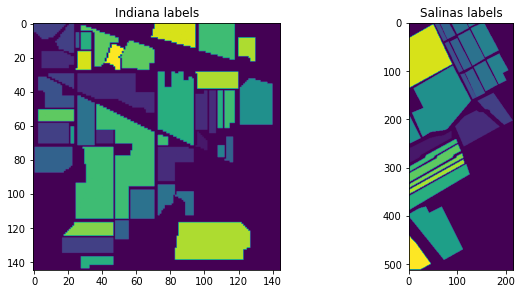

In [8]:
# Display ground truth for each image
plot_two_figures(indiana_labels, salinas_labels, title_fig1='Indiana labels', title_fig2='Salinas labels')

## Remove unclassified data

We will use a supervised learning algorithm. We have to remove data without labels (considered as the background of the ground truth) to allow our model to recognize the different classes. 

In [9]:
X_indiana, X_indiana_idx = remove_unclassified_input(X_indiana, indiana_labels)
X_salinas, X_salinas_idx = remove_unclassified_input(X_salinas, salinas_labels)

In [10]:
indiana_labels, _ = remove_unclassified_input(indiana_labels.flatten(), indiana_labels)
salinas_labels, _ = remove_unclassified_input(salinas_labels.flatten(), salinas_labels)

## PCA

PCA stands for principal component analysis. PCA is an unsupervised technique used for reduce the dimensions of the dataset. It transforms the dataset reducing the number of components in order to decrease the computational complexity of the model. 

To reduce the number of component, the PCA computes a linear transformation performing a linear mapping of the data to a lower-dimensional space. It aims to reduce the dimensions with a maximized variance of the data.

In [11]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [12]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 68
Number of components Salinas: 5


After retrieving the optimal number of components for each image, we need to compute a second PCA for each image to extract their features.

In [13]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [14]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (10249, 68)
Salinas reduced data shape: (54129, 5)


## Split data into train / test

We will use a supervised learning algorithm. We need to split our dataset into training and testing dataset. To be sure that our splitting is efficient, we decided to split data for each label.
In addition, we decided to shuffle our data so that the split does not return us the first values of each label in the ground truth. 

We are going to use 75% of the data as the training dataset and 25% for the testing.



If we split directly over all the data, it is possible that all the samples of a class are in the train data (when the class contains few samples).

In [15]:
# shuffle manually
X_indiana_shuffle, indiana_labels_shuffle, shuffle_arr_indiana = shuffle(X_indiana_reduced, indiana_labels)
X_salinas_shuffle, salinas_labels_shuffle, shuffle_arr_salinas = shuffle(X_salinas_reduced, salinas_labels)

In [16]:
y_indiana_labels_argsort = np.argsort(indiana_labels_shuffle)
y_salinas_labels_argsort = np.argsort(salinas_labels_shuffle)

In [17]:
labels_indiana, count_indiana = np.unique(indiana_labels_shuffle-1, return_counts=True)
labels_salinas, count_salinas = np.unique(salinas_labels_shuffle-1, return_counts=True)

In [18]:
x_train_indiana, x_test_indiana, y_train_indiana_labels, y_test_indiana_labels = split_x_train_test(X_indiana_shuffle, count_indiana, labels_indiana, y_indiana_labels_argsort, (0, n_components_indiana))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Nb samples train,34,1071,622,177,362,547,21,358,15,729,1841,444,153,948,289,69
Nb samples test,12,357,208,60,121,183,7,120,5,243,614,149,52,317,97,24
Nb total samples,46,1428,830,237,483,730,28,478,20,972,2455,593,205,1265,386,93


In [19]:
x_train_salinas, x_test_salinas, y_train_salinas_labels, y_test_salinas_labels = split_x_train_test(X_salinas_shuffle, count_salinas, labels_salinas, y_salinas_labels_argsort, (0, n_components_salinas))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Nb samples train,1506,2794,1482,1045,2008,2969,2684,8453,4652,2458,801,1445,687,802,5451,1355
Nb samples test,503,932,494,349,670,990,895,2818,1551,820,267,482,229,268,1817,452
Nb total samples,2009,3726,1976,1394,2678,3959,3579,11271,6203,3278,1068,1927,916,1070,7268,1807


In [20]:
print("Indiana - Train shape: {}".format(x_train_indiana.shape))
print("Indiana - Train labels shape: {}".format(y_train_indiana_labels.shape))
print("Indiana - Test shape: {}".format(x_test_indiana.shape))
print("Indiana - Test labels shape: {}".format(y_test_indiana_labels.shape))

Indiana - Train shape: (7680, 68)
Indiana - Train labels shape: (7680,)
Indiana - Test shape: (2569, 68)
Indiana - Test labels shape: (2569,)


In [21]:
print("Salinas - Train shape: {}".format(x_train_salinas.shape))
print("Salinas - Train labels shape: {}".format(y_train_salinas_labels.shape))
print("Salinas - Test shape: {}".format(x_test_salinas.shape))
print("Salinas - Test labels shape: {}".format(y_test_salinas_labels.shape))

Salinas - Train shape: (40592, 5)
Salinas - Train labels shape: (40592,)
Salinas - Test shape: (13537, 5)
Salinas - Test labels shape: (13537,)


We can display the histograms to verify that our split is working well and that no data is lost.

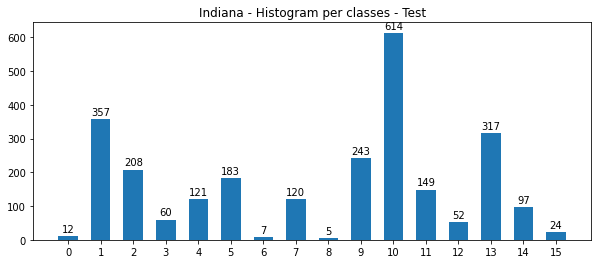

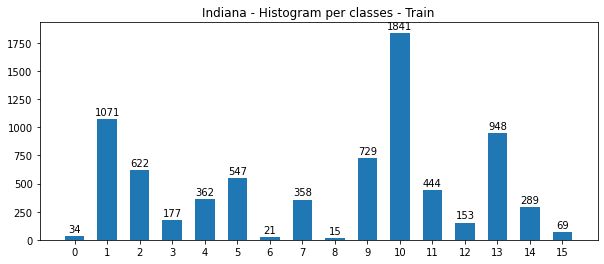

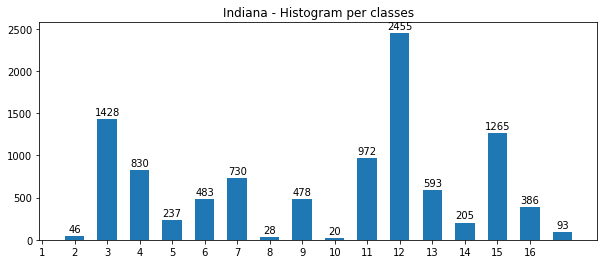

In [22]:
plot_histogram(y_test_indiana_labels, title='Indiana - Histogram per classes - Test')
plot_histogram(y_train_indiana_labels, title='Indiana - Histogram per classes - Train')
plot_histogram(indiana_labels, title='Indiana - Histogram per classes')

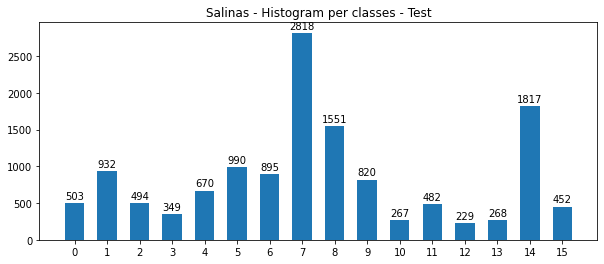

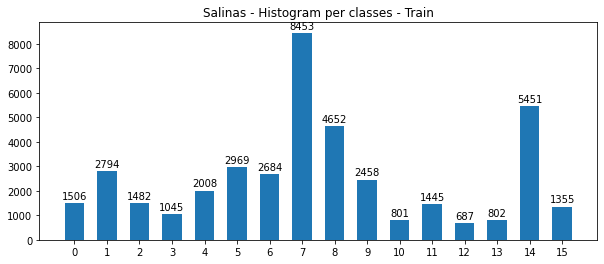

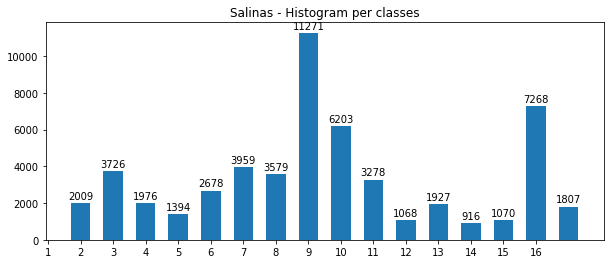

In [23]:
plot_histogram(y_test_salinas_labels, title='Salinas - Histogram per classes - Test')
plot_histogram(y_train_salinas_labels, title='Salinas - Histogram per classes - Train')
plot_histogram(salinas_labels, title='Salinas - Histogram per classes')

We can see that the histogram variations are the same for each data set, which means there is no loss of information. 

# OneVsOneClassifier using SVC

### SVC

SVC stands for Support Vector Classification.

SVC uses the Support Vector Domain Description (SVDD) to delineate the region in data space using a kernel function. The main goal of SVC is to divide the datasets into number of classes in order to find a maximum marginal hyperplane that separates the classes in the best way.

### OneVsOneClassifier

OneVsOneClassifier constructs a classifier for each pair of classes. During the prediction, the class with the highest votes is returned. If two classes have the same number of votes, the class with the highest aggregate classification confidence is returned.

In [24]:
indiana_modelSVC = SVC(random_state=0, verbose=1)
salinas_modelSVC = SVC(random_state=0, verbose=1)

In [25]:
indiana_model = OneVsOneClassifier(indiana_modelSVC, n_jobs=8)
salinas_model = OneVsOneClassifier(salinas_modelSVC, n_jobs=8)

In [26]:
%%time
indiana_model.fit(x_train_indiana, y_train_indiana_labels)

CPU times: user 109 ms, sys: 84.5 ms, total: 193 ms
Wall time: 1.12 s


OneVsOneClassifier(estimator=SVC(random_state=0, verbose=1), n_jobs=8)

In [27]:
%%time
salinas_model.fit(x_train_salinas, y_train_salinas_labels)

CPU times: user 74 ms, sys: 5.98 ms, total: 80 ms
Wall time: 3.15 s


OneVsOneClassifier(estimator=SVC(random_state=0, verbose=1), n_jobs=8)

### Scores

In [28]:
%%time
indiana_train_score = indiana_model.score(x_train_indiana, y_train_indiana_labels)
indiana_test_score = indiana_model.score(x_test_indiana, y_test_indiana_labels)

print('Indiana - training score: {}'.format(indiana_train_score))
print('Indiana - testing score: {}'.format(indiana_test_score))

Indiana - training score: 0.7782552083333333
Indiana - testing score: 0.7594394706111327
CPU times: user 13.9 s, sys: 58.9 ms, total: 14 s
Wall time: 14 s


In [29]:
%%time
salinas_train_score = salinas_model.score(x_train_salinas, y_train_salinas_labels)
salinas_test_score = salinas_model.score(x_test_salinas, y_test_salinas_labels)

print('Salinas - training score: {}'.format(salinas_train_score))
print('Salinas - testing score: {}'.format(salinas_test_score))

Salinas - training score: 0.8991673236105636
Salinas - testing score: 0.8988697643495605
CPU times: user 52.7 s, sys: 111 ms, total: 52.8 s
Wall time: 52.9 s


We can notice that the scores of the train and the tests are very close which means that our models do not overfit. 

We think that the score method of the model is not enough accurate so we will compute our own score calculation.

In [30]:
%%time
indiana_train_mean_score = calculate_mean_score(labels_indiana, x_train_indiana, y_train_indiana_labels, indiana_model)
print("Indiana train mean score: {}".format(indiana_train_mean_score))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.00000,7.000000,8.0,9.000000,10.000000,11.000000,12.000000,13.000000,14.00000,15.000000
Nb samples,34.000000,1071.000000,622.000000,177.000000,362.000000,547.000000,21.00000,358.000000,15.0,729.000000,1841.000000,444.000000,153.000000,948.000000,289.00000,69.000000
Score,0.441176,0.680672,0.474277,0.276836,0.798343,0.981718,0.52381,0.997207,0.0,0.688615,0.896795,0.567568,0.954248,0.984177,0.50519,0.942029


Indiana train mean score: 0.6695413040424163
CPU times: user 11.4 s, sys: 5.22 ms, total: 11.4 s
Wall time: 11.4 s


In [31]:
%%time
indiana_test_mean_score = calculate_mean_score(labels_indiana, x_test_indiana, y_test_indiana_labels, indiana_model)
print("Indiana test mean score: {}".format(indiana_test_mean_score))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0.000000,1.000000,2.000000,3.000000,4.00000,5.000000,6.000000,7.000000,8.0,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000
Nb samples,12.000000,357.000000,208.000000,60.000000,121.00000,183.000000,7.000000,120.000000,5.0,243.000000,614.000000,149.000000,52.000000,317.000000,97.000000,24.000000
Score,0.166667,0.635854,0.447115,0.216667,0.85124,0.994536,0.285714,0.991667,0.0,0.711934,0.879479,0.503356,0.980769,0.981073,0.391753,0.916667


Indiana test mean score: 0.6221555574382637
CPU times: user 3.87 s, sys: 2.06 ms, total: 3.87 s
Wall time: 3.91 s


In [32]:
%%time
salinas_train_mean_score = calculate_mean_score(labels_salinas, x_train_salinas, y_train_salinas_labels, salinas_model)
print("Salinas train mean score: {}".format(salinas_train_mean_score))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0.000000,1.000000,2.00000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.00000,13.000000,14.000000,15.00000
Nb samples,1506.000000,2794.000000,1482.00000,1045.000000,2008.000000,2969.000000,2684.000000,8453.000000,4652.000000,2458.000000,801.000000,1445.000000,687.00000,802.000000,5451.000000,1355.00000
Score,0.968127,0.993558,0.97166,0.995215,0.958167,0.997305,0.994039,0.878741,0.975924,0.898291,0.897628,0.999308,0.97671,0.942643,0.578976,0.96679


Salinas train mean score: 0.9370677792135831
CPU times: user 38.3 s, sys: 25.4 ms, total: 38.3 s
Wall time: 38.4 s


In [33]:
%%time
salinas_test_mean_score = calculate_mean_score(labels_salinas, x_test_salinas, y_test_salinas_labels, salinas_model)
print("Salinas test mean score: {}".format(salinas_test_mean_score))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0.000000,1.000000,2.000000,3.000000,4.000000,5.0,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.00000,14.000000,15.000000
Nb samples,503.000000,932.000000,494.000000,349.000000,670.000000,990.0,895.000000,2818.000000,1551.000000,820.000000,267.000000,482.000000,229.000000,268.00000,1817.000000,452.000000
Score,0.974155,0.988197,0.955466,0.997135,0.958209,1.0,0.993296,0.871185,0.976789,0.902439,0.910112,0.993776,0.982533,0.94403,0.586131,0.975664


Salinas test mean score: 0.9380698014997029
CPU times: user 12.6 s, sys: 9.75 ms, total: 12.6 s
Wall time: 12.6 s


With our method, salinas' scores are better whereas indiana's scores decreased.

### Predictions

In [34]:
%%time
indiana_preds_test = indiana_model.predict(x_test_indiana)
indiana_preds_train = indiana_model.predict(x_train_indiana)

CPU times: user 13 s, sys: 5.33 ms, total: 13 s
Wall time: 13 s


In [35]:
%%time
salinas_preds_test = salinas_model.predict(x_test_salinas)
salinas_preds_train = salinas_model.predict(x_train_salinas)

CPU times: user 49.5 s, sys: 27.3 ms, total: 49.5 s
Wall time: 49.6 s


Both scores are high and we want to know if every classes are well recognized.

We can display a histogram containing the number of expected and predicted labels. 

Analyzing our results from a histogram only allows us to determine the number of images per class. We therefore lose a certain amount of information, including the differentiation between false positives and false negatives for each class. This method therefore makes it possible to have a global idea of the efficiency of our model but we cannot deduce much information from it.

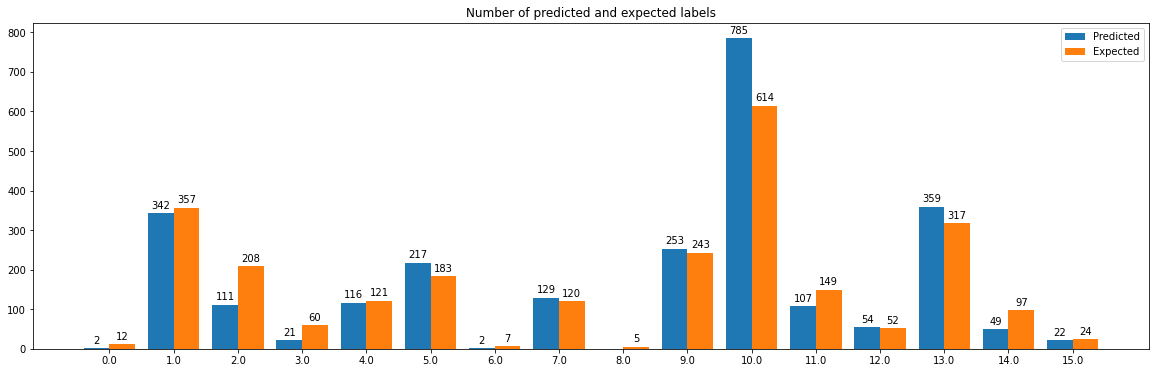

In [36]:
plot_histogram_compare_predict_expect(indiana_preds_test, y_test_indiana_labels)

As we can notice, our model classify too much samples into class 10. We can also notice that some classes with only a few samples are well recognized (0, 6 and 15) but the class 5 is not recognized at all.

We will display a confusion matrix.
A confusion matrix is used to highlight false positives and false negatives. The diagonal corresponds to the true positive which makes it possible to visualize more easily the classes having fairly large prediction errors.

By the way, we decided to display this matrix using coloring. This can be done using a linear or logarithmic scale. The logarithmic scale makes it possible to highlight the different variations. 

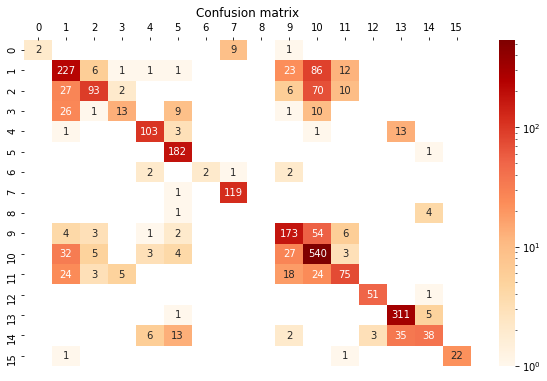

In [37]:
plot_confusion_matrix(y_test_indiana_labels, indiana_preds_test, class_names=indiana_class_names, log=True)

A row corresponds to the number of expected labels and a column is the number that we predicted.

What can we deduce from the confusion matrix ?

We can see that our model considered some samples from class 1 as class 10. These two classes may have a lot of similarity because there are also some samples from class 10 which are considered as class 1.

We can notice that samples from class 15 are well recognized. There are no true negative or false positive whereas all samples from class 12 are well recognized but there are also 4 false positives.

A classification report contains informations based on true positives, false positives and false negative:
* precision: the number of true positives divided by the number of false positives plus true positives
* recall:  the number of true positives divided by the number of true positives plus false negatives
* f1-score: harmonic mean of the model's precision and recall
* support: the number of occurrence



In [38]:
print(classification_report(y_test_indiana_labels, indiana_preds_test, target_names=indiana_class_names))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.66      0.64      0.65       357
           2       0.84      0.45      0.58       208
           3       0.62      0.22      0.32        60
           4       0.89      0.85      0.87       121
           5       0.84      0.99      0.91       183
           6       1.00      0.29      0.44         7
           7       0.92      0.99      0.96       120
           8       0.00      0.00      0.00         5
           9       0.68      0.71      0.70       243
          10       0.69      0.88      0.77       614
          11       0.70      0.50      0.59       149
          12       0.94      0.98      0.96        52
          13       0.87      0.98      0.92       317
          14       0.78      0.39      0.52        97
          15       1.00      0.92      0.96        24

    accuracy                           0.76      2569
   macro avg       0.78   

/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With the classification report, we can notice that the lower f1-score for this model is 0.61 (if we do not care about class 8) which is correct. This model can recognize most of the classes.

We can also perform the same operations for salinas image.

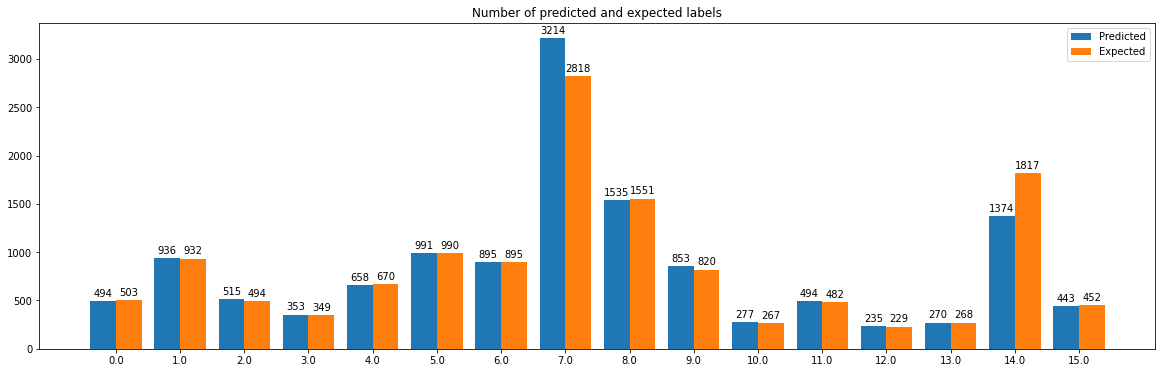

In [39]:
plot_histogram_compare_predict_expect(salinas_preds_test, y_test_salinas_labels)

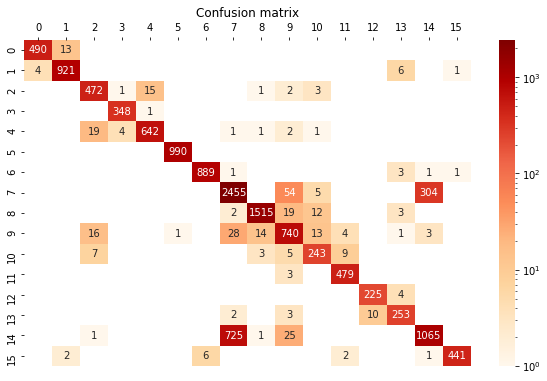

In [40]:
plot_confusion_matrix(y_test_salinas_labels, salinas_preds_test, class_names=salinas_class_names, log=True)

In [41]:
print(classification_report(y_test_salinas_labels, salinas_preds_test, target_names=salinas_class_names))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       503
           1       0.98      0.99      0.99       932
           2       0.92      0.96      0.94       494
           3       0.99      1.00      0.99       349
           4       0.98      0.96      0.97       670
           5       1.00      1.00      1.00       990
           6       0.99      0.99      0.99       895
           7       0.76      0.87      0.81      2818
           8       0.99      0.98      0.98      1551
           9       0.87      0.90      0.88       820
          10       0.88      0.91      0.89       267
          11       0.97      0.99      0.98       482
          12       0.96      0.98      0.97       229
          13       0.94      0.94      0.94       268
          14       0.78      0.59      0.67      1817
          15       1.00      0.98      0.99       452

    accuracy                           0.90     13537
   macro avg       0.94   

The classification on this image is obviously better. This is mainly due to the fact that all classes have at least 200 samples. We can notice that the model has difficulty distinguishing between labels 8 and 14. 

### Prediction on images

In [42]:
%%time
preds_indiana = indiana_model.predict(X_indiana_reduced)

CPU times: user 12.9 s, sys: 1.81 ms, total: 12.9 s
Wall time: 12.9 s


In [43]:
%%time
preds_salinas = salinas_model.predict(X_salinas_reduced)

CPU times: user 50.5 s, sys: 37.8 ms, total: 50.5 s
Wall time: 50.6 s


In [44]:
indiana_preds_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
indiana_label_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))

In [45]:
indiana_preds_img[X_indiana_idx] = preds_indiana + 1
indiana_preds_img = indiana_preds_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))

In [46]:
indiana_label_img[X_indiana_idx] = indiana_labels
indiana_label_img = indiana_label_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))

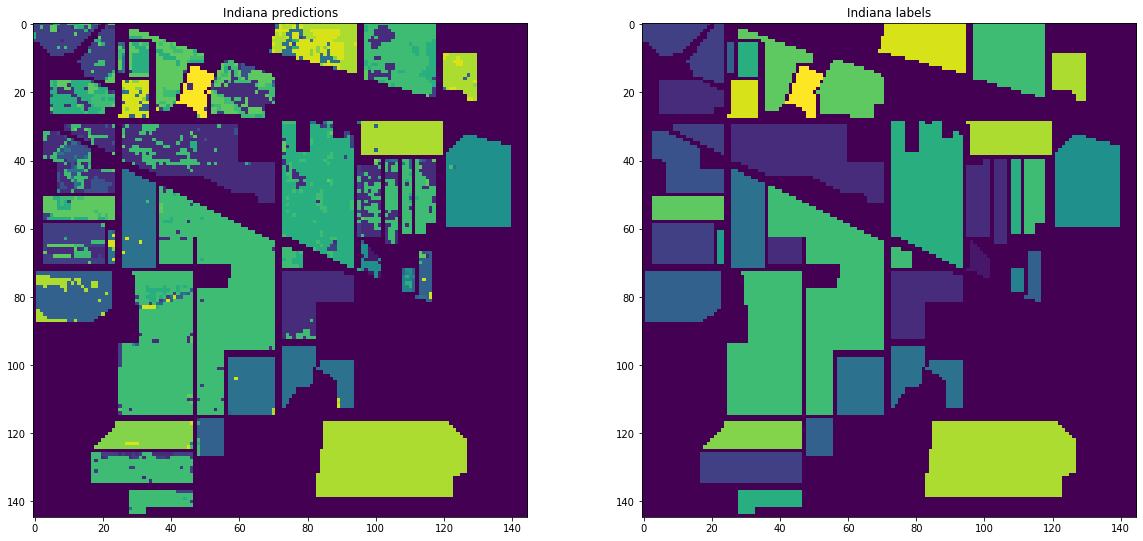

In [47]:
plot_two_figures(indiana_preds_img, indiana_label_img, 'Indiana predictions', 'Indiana labels', figsize=(20, 20))

On these pictures, we have the impression that our classification is correct but we have to display each label to be sure.

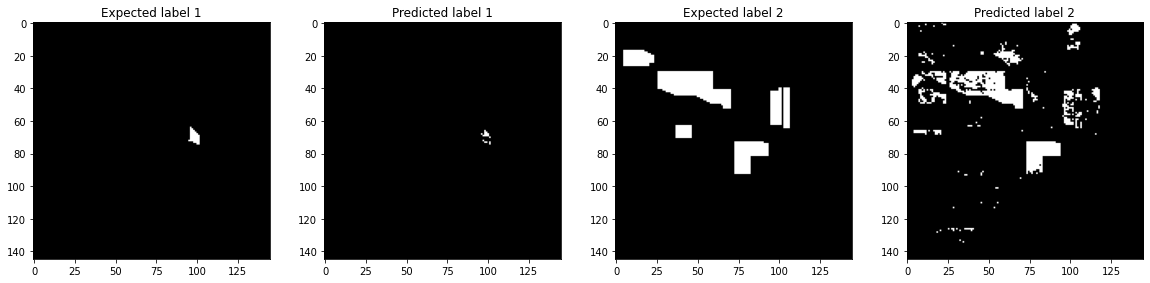

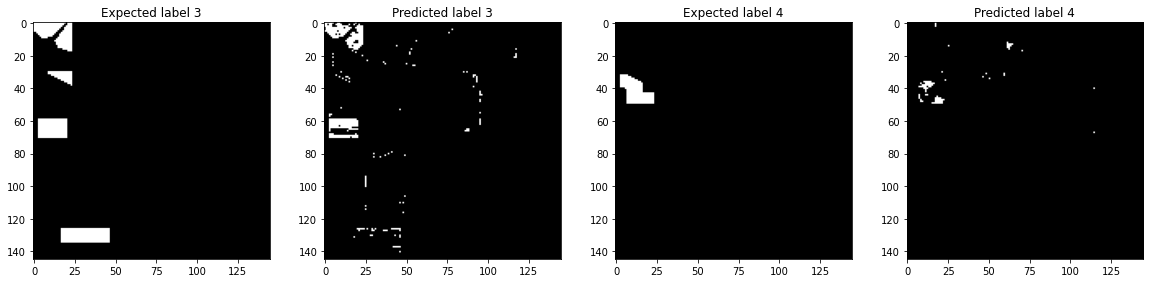

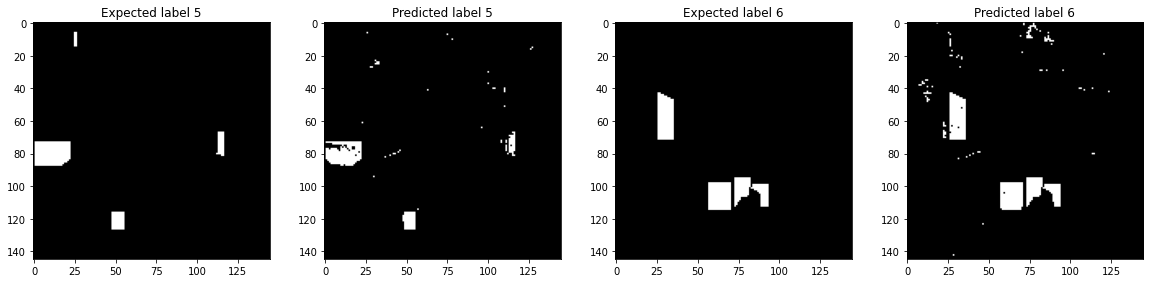

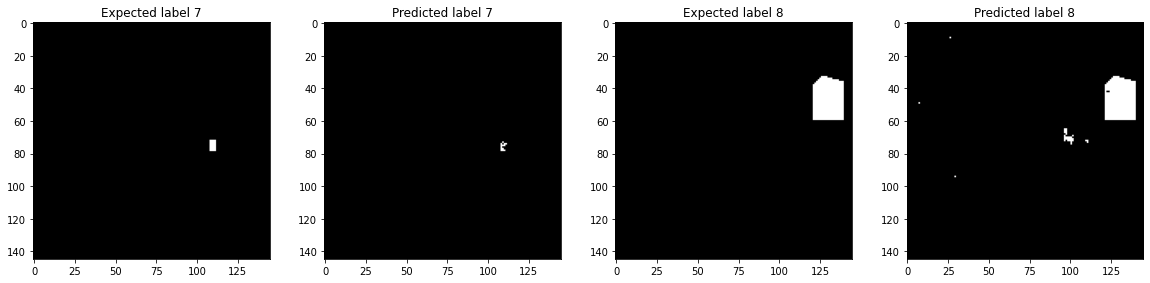

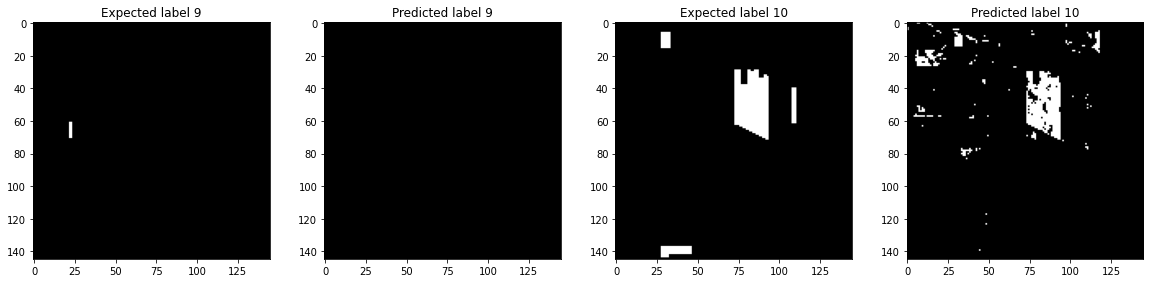

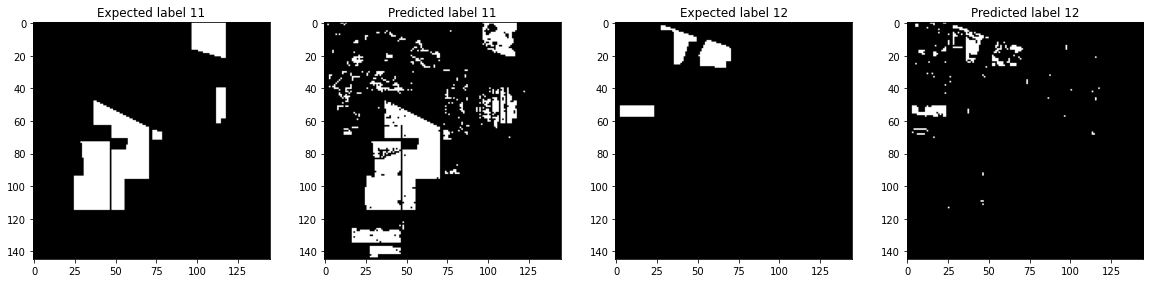

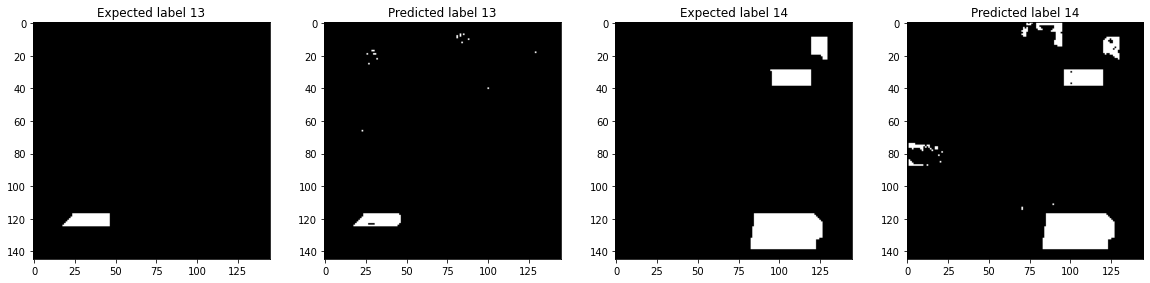

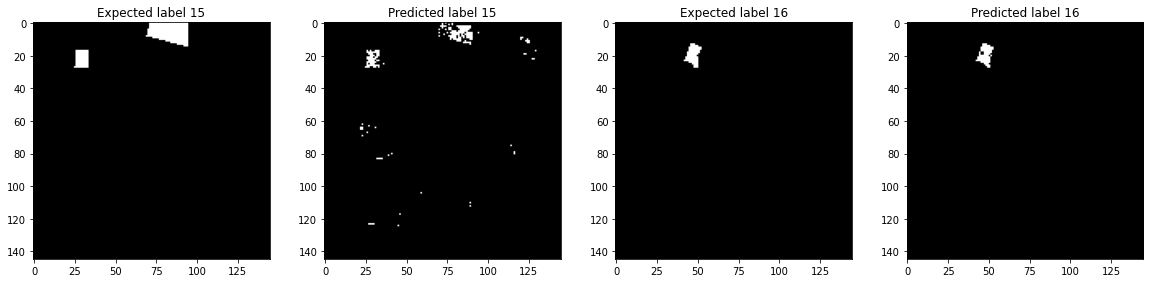

In [48]:
plot_each_labels(indiana_label_img, indiana_preds_img, n_cluster_indiana, figsize=(20, 20), cmap='gray')

As we can see, every classes are well recognized but there are a lot a noise. For instance, on the label 11, there is a lot of noise on the middle part which means that too much samples have been classified to this class.

In [49]:
salinas_preds_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))
salinas_label_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))

In [50]:
salinas_preds_img[X_salinas_idx] = preds_salinas + 1
salinas_preds_img = salinas_preds_img.reshape((salinas_img.shape[0], salinas_img.shape[1]))

In [51]:
salinas_label_img[X_salinas_idx] = salinas_labels
salinas_label_img = salinas_label_img.reshape((salinas_img.shape[0], salinas_img.shape[1]))

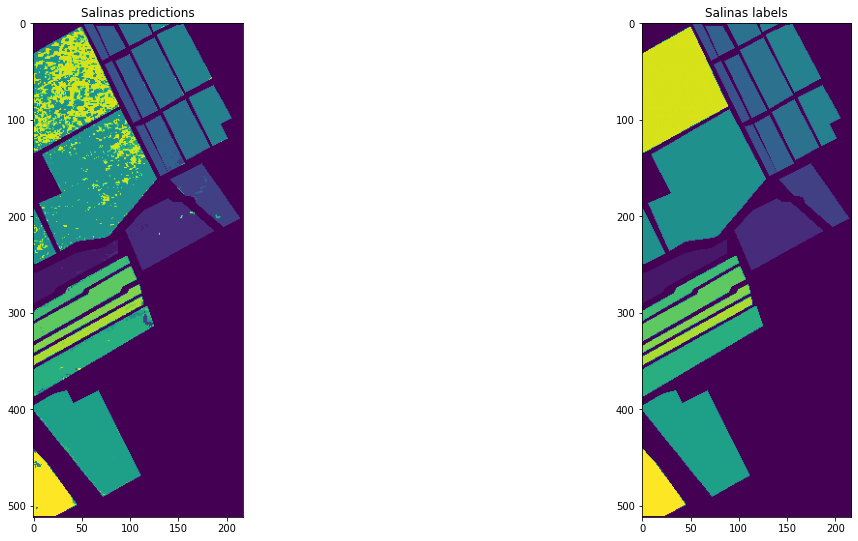

In [52]:
plot_two_figures(salinas_preds_img, salinas_label_img, 'Salinas predictions', 'Salinas labels', figsize=(20, 20))

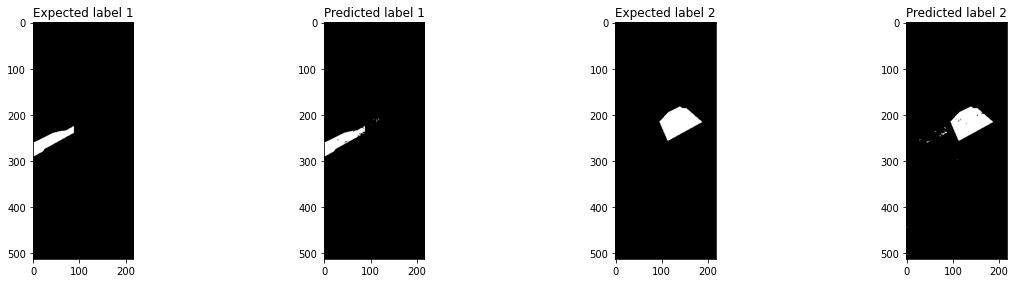

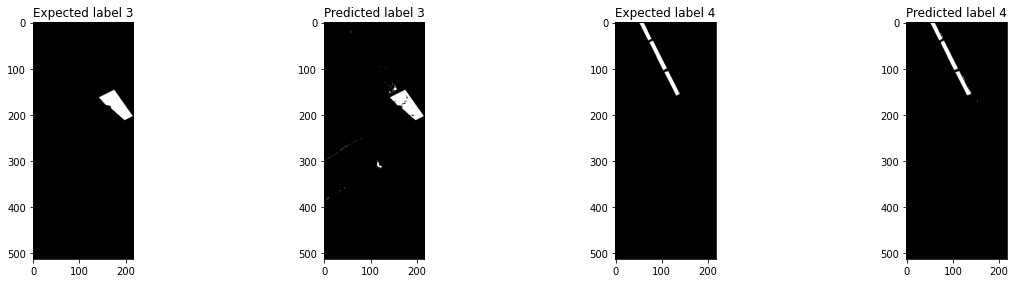

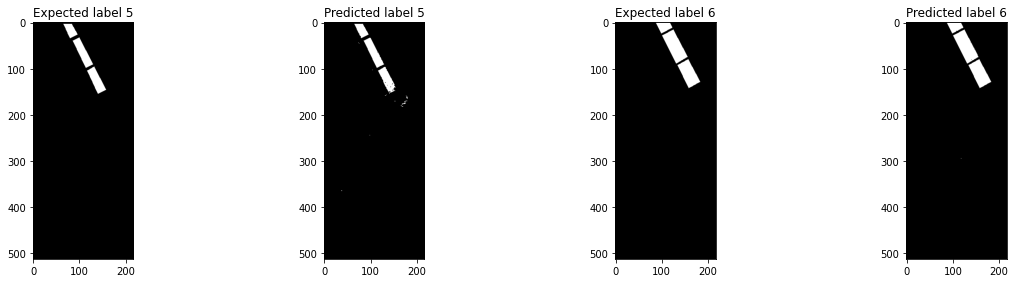

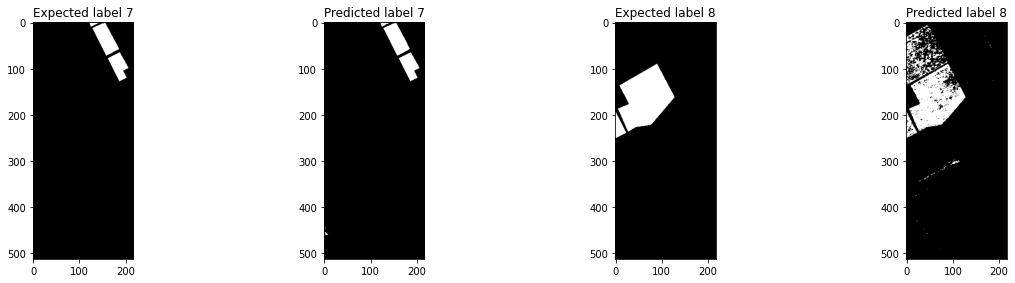

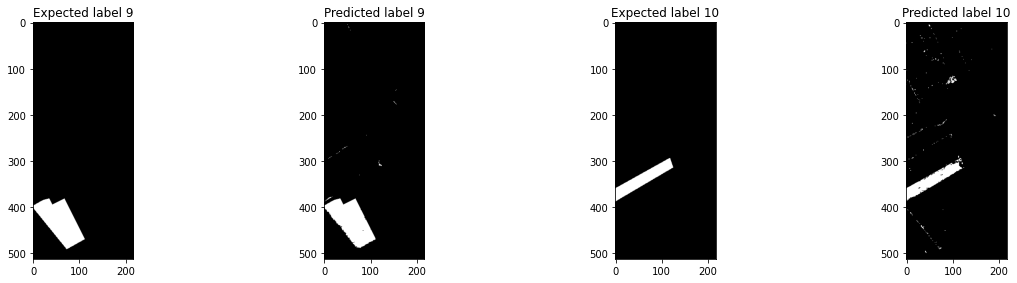

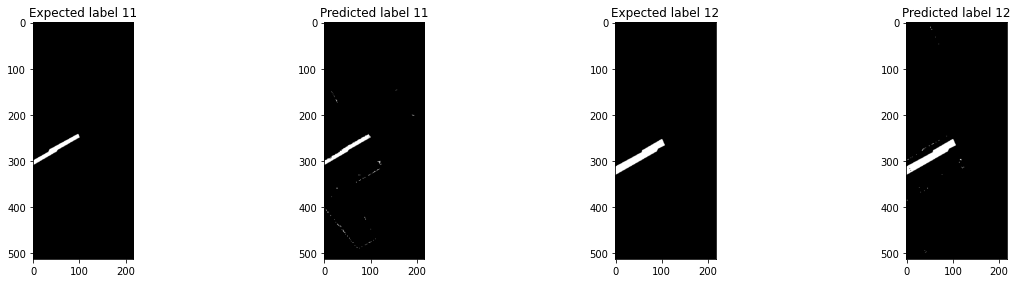

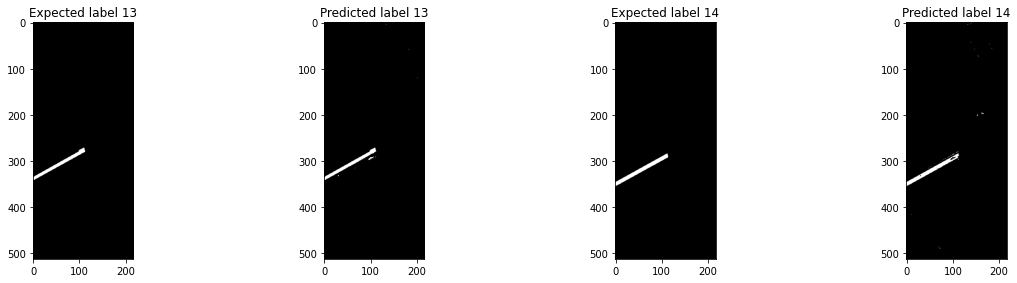

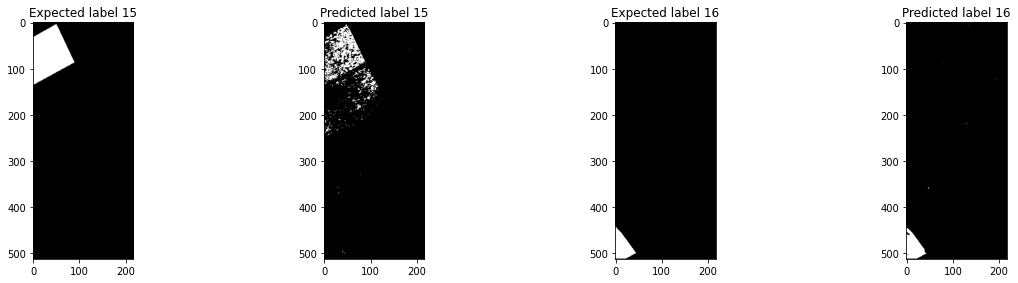

In [53]:
plot_each_labels(salinas_label_img, salinas_preds_img, n_cluster_salinas, figsize=(20, 20), cmap='gray')

We decided to display classification report on the whole image to have an idea about how many percent of each class is recognized. However, the model predicts on training and testing data.

In [54]:
print(classification_report(indiana_label_img.flatten(), indiana_preds_img.flatten()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10776
         1.0       1.00      0.37      0.54        46
         2.0       0.69      0.67      0.68      1428
         3.0       0.82      0.47      0.59       830
         4.0       0.71      0.26      0.38       237
         5.0       0.91      0.81      0.86       483
         6.0       0.87      0.98      0.92       730
         7.0       1.00      0.46      0.63        28
         8.0       0.94      1.00      0.96       478
         9.0       0.00      0.00      0.00        20
        10.0       0.71      0.69      0.70       972
        11.0       0.70      0.89      0.78      2455
        12.0       0.74      0.55      0.63       593
        13.0       0.92      0.96      0.94       205
        14.0       0.87      0.98      0.92      1265
        15.0       0.81      0.48      0.60       386
        16.0       0.99      0.94      0.96        93

    accuracy              

/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
print(classification_report(salinas_label_img.flatten(), salinas_preds_img.flatten()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56975
         1.0       0.99      0.97      0.98      2009
         2.0       0.98      0.99      0.99      3726
         3.0       0.92      0.97      0.94      1976
         4.0       0.98      1.00      0.99      1394
         5.0       0.98      0.96      0.97      2678
         6.0       1.00      1.00      1.00      3959
         7.0       0.99      0.99      0.99      3579
         8.0       0.76      0.88      0.82     11271
         9.0       0.99      0.98      0.98      6203
        10.0       0.87      0.90      0.88      3278
        11.0       0.87      0.90      0.89      1068
        12.0       0.97      1.00      0.98      1927
        13.0       0.95      0.98      0.97       916
        14.0       0.95      0.94      0.95      1070
        15.0       0.78      0.58      0.67      7268
        16.0       0.99      0.97      0.98      1807

    accuracy              

Using the default SVC we have decent and somewhat better results. We hit almost 0.90 on Indiana and 0.95 on Salinas. 

We can deduce that OneVsOneClassifier with default SVC is good enough to classify both images.

## Save predictions

In order to be able to compare models , we save our prediction data on each image. We also save model's score.

In [56]:
np.save('../data/predictions/indiana_preds_SVC.npy', indiana_preds_img)
np.save('../data/predictions/salinas_preds_SVC.npy', salinas_preds_img)

In [57]:
# Check if csv file exists
try:
    df = pd.read_csv('../data/score.csv')
except Exception:
    cols = ['model', 'image', 'test_score', 'train_score', 'mean_test_score', 'mean_train_score']
    df = pd.DataFrame(columns=cols)

In [58]:
df.loc[df.shape[0]] = ['OneVsOneClassifier - SVC', 'indiana', indiana_test_score, indiana_train_score, indiana_test_mean_score, indiana_train_mean_score]
df.loc[df.shape[0]] = ['OneVsOneClassifier - SVC', 'salinas', salinas_test_score, salinas_train_score, salinas_test_mean_score, salinas_train_mean_score]

In [59]:
df.to_csv('../data/score.csv', index=False)